<a href="https://colab.research.google.com/github/s-kp/CapstoneProject-FaceEmotionRecognition/blob/main/FER_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Table of Contents**

- [1 - Project Introduction](#1)
- [2 - Importing Libraries](#2)
- [3 - Defining Prerequisites](#2)
- [4 - MobileNetV2](#2)
- [5 - VGG16](#2)
- [6 - VGG19](#2)

<a name='1'></a>
# **Project Introduction**


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

## **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

**Face Emotion Recognition:**
This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.

<a name='2'></a>
# **Importing Libraries**

In [ ]:
# Importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os 
tf.random.set_seed(42)

In [ ]:
# Downloading the dataset
!gdown --id 1kdAI0wrR_bTBs-6pbKB6giz-JcNaTY-s

# Unzipping the files
!unzip '/content/dataset.zip'

In [ ]:
# Defining te path of train and test dataset
train_dir = '/content/train'
test_dir = '/content/test'

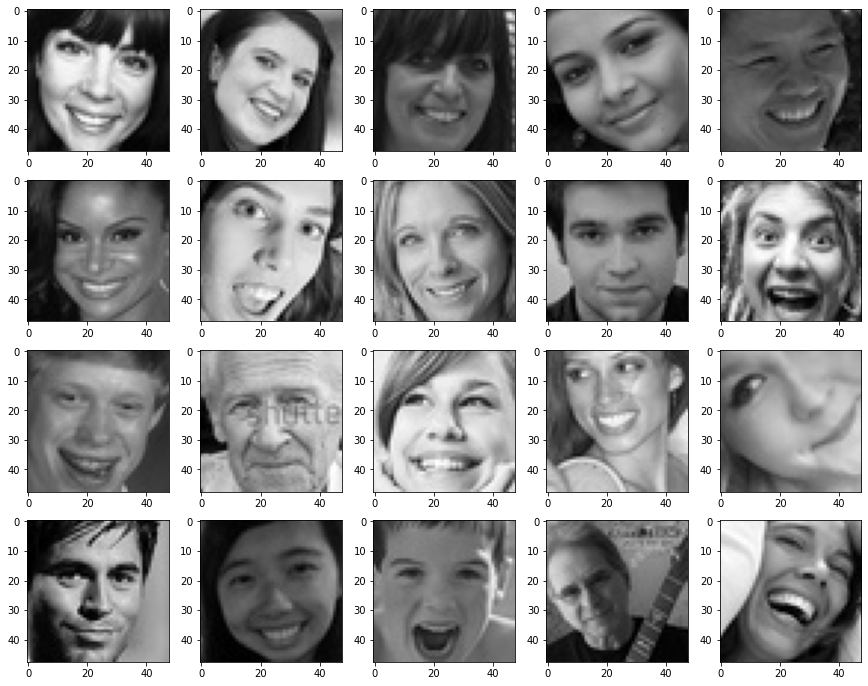

In [ ]:
# Displaying sample Images
path = '/content/train/happy/'
plt.figure(figsize=(15,12))
for i in range(1, 21):
    plt.subplot(4,5,i)
    img = load_img(path + os.listdir(path)[i])
    plt.imshow(img)   
plt.show()

In [ ]:
# Generating batches of tensor image data with real-time data augmentation.
batch = 64
img = (48,48)
color = "grayscale"
valid_gen = ImageDataGenerator(rescale=1./255)
train_gen = ImageDataGenerator(rotation_range=20, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True,
                              width_shift_range=0.1, height_shift_range=0.1)

train_data = train_gen.flow_from_directory(train_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")
validation = valid_gen.flow_from_directory(test_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


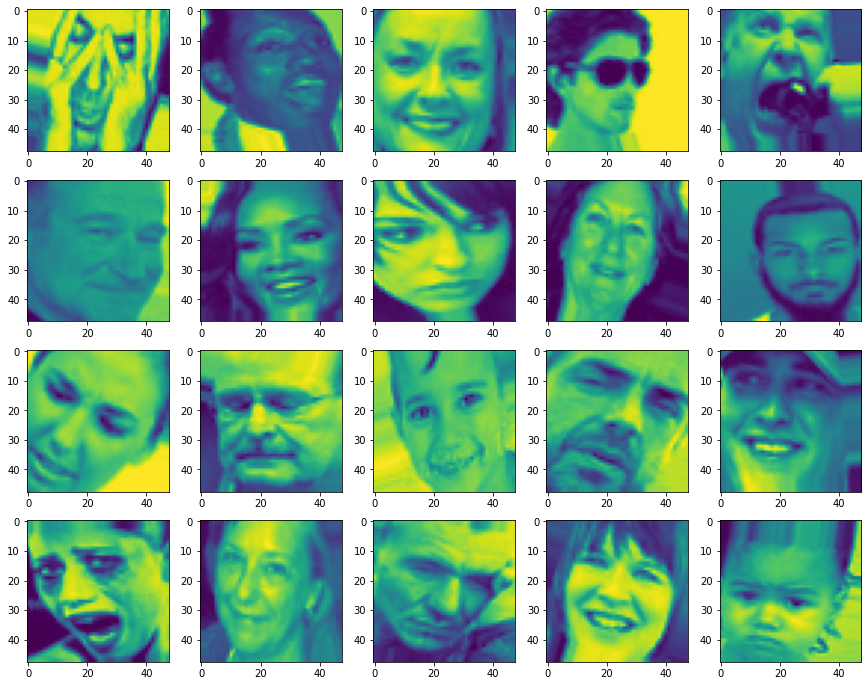

In [ ]:
# Displaying sample images from the training set after augmentation
random_image = np.random.choice(64, size=20, replace=False)
random_batch = np.random.choice(112,size=20, replace=False)
fig,axes=plt.subplots(4,5,figsize=(15,12))
for id, ax in enumerate(axes.flatten()):
  pic = train_data[random_batch[id]][0][random_image[id]]
  ax.imshow(pic.reshape(48,-1))

In [ ]:
# checking te shape of image and the label
image_batch, label_batch = next(iter(train_data))
print('image shape',image_batch[0].shape)
print('Label shape',label_batch[0].shape)

image shape (48, 48, 1)
Label shape (7,)


<a name='2'></a>
# **Defining prerequisites**

In [ ]:
# Defining a function to generate callbacks
def callback_list(name):

    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(f"{name}.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    # Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=9, verbose=1, restore_best_weights=True)
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
    # Defining a list of all the callbacks
    callbacks = [earlystop, checkpoint, reduce_lr]

    return callbacks

In [ ]:
def plots(history):
    # Plot the training and validation accuracy
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

<a name='2'></a>
# **Mobilenet**

In [ ]:
# categorical classification using MobileNetV2 
model1 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                     Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                     # Using MobileNetV2
                     MobileNetV2(weights='imagenet', include_top=False, pooling = 'avg'),
                     # Using a fully connected layer with 128 units and relu activation
                     Dense(128, activation='relu'),
                     # Using a fully connected layer with 64 units and relu activation
                     Dense(64, activation='relu'),
                     # Using a prediction layer with seven neuron
                     Dense(7, activation='softmax')])

# Compiling the model
model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
model1.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 3)         30        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2,430,693
Trainable params: 2,396,581
Non-tra

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fitting the model
history = model1.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('mobilenet'))

Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.8550 - accuracy: 0.2429
Epoch 1: val_loss improved from inf to 1.87348, saving model to mobilenet.h5
449/449 [==============================] - 46s 68ms/step - loss: 1.8547 - accuracy: 0.2432 - val_loss: 1.8735 - val_accuracy: 0.2442 - lr: 1.0000e-04
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.7203 - accuracy: 0.3128
Epoch 2: val_loss improved from 1.87348 to 1.81766, saving model to mobilenet.h5
449/449 [==============================] - 29s 65ms/step - loss: 1.7205 - accuracy: 0.3128 - val_loss: 1.8177 - val_accuracy: 0.2531 - lr: 1.0000e-04
Epoch 3/100
448/449 [============================>.] - ETA: 0s - loss: 1.6599 - accuracy: 0.3426
Epoch 3: val_loss improved from 1.81766 to 1.80717, saving model to mobilenet.h5
449/449 [==============================] - 28s 62ms/step - loss: 1.6598 - accuracy: 0.3426 - val_loss: 1.8072 - val_accuracy: 0.2724 - lr: 1.0000e-04
Epoch 4/100
448/449 

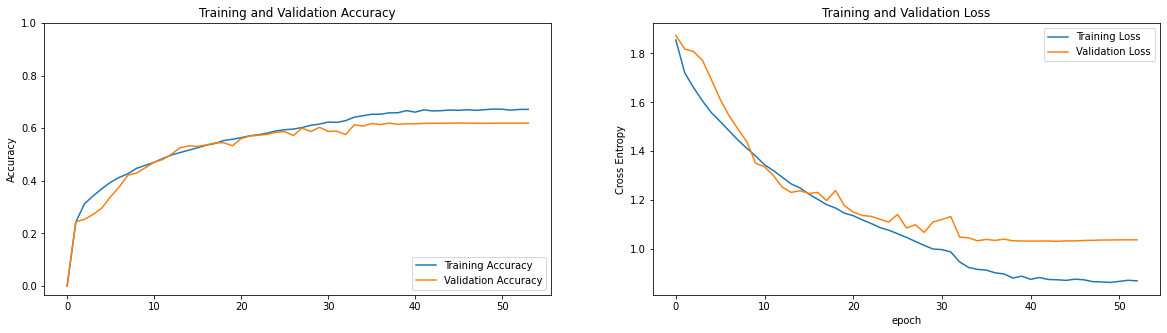

In [ ]:
# Plotting te accuracy and loss
plots(history)

<a name='2'></a>
# **VGG16**

In [ ]:
# categorical classification using VGG16 
model2 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                     Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                     # Using VGG16 and Flattening the output
                     VGG16(include_top=False), Flatten(), BatchNormalization(),
                     # Using 2 fully connected layer with 4096 units and relu activation
                     Dense(4096, activation='relu'), BatchNormalization(),
                     Dense(4096, activation='relu'), BatchNormalization(),
                     # Using a prediction layer with seven neuron
                     Dense(7, activation='softmax')])

# Compiling the model
model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 3)         30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 4096)              2101248   
                                                                 
 batch_normalization_4 (Batc  (None, 4096)             16384     
 hNormalization)                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fitting the model
history = model2.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('vgg16'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8755 - accuracy: 0.3089
Epoch 1: val_loss improved from inf to 9.15998, saving model to vgg16.h5
449/449 [==============================] - 37s 80ms/step - loss: 1.8755 - accuracy: 0.3089 - val_loss: 9.1600 - val_accuracy: 0.1160 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5078 - accuracy: 0.4279
Epoch 2: val_loss improved from 9.15998 to 2.85609, saving model to vgg16.h5
449/449 [==============================] - 36s 80ms/step - loss: 1.5078 - accuracy: 0.4279 - val_loss: 2.8561 - val_accuracy: 0.2144 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.3820 - accuracy: 0.4778
Epoch 3: val_loss improved from 2.85609 to 2.48691, saving model to vgg16.h5
449/449 [==============================] - 35s 77ms/step - loss: 1.3820 - accuracy: 0.4778 - val_loss: 2.4869 - val_accuracy: 0.3194 - lr: 1.0000e-04
Epoch 4/100
449/449 [===========

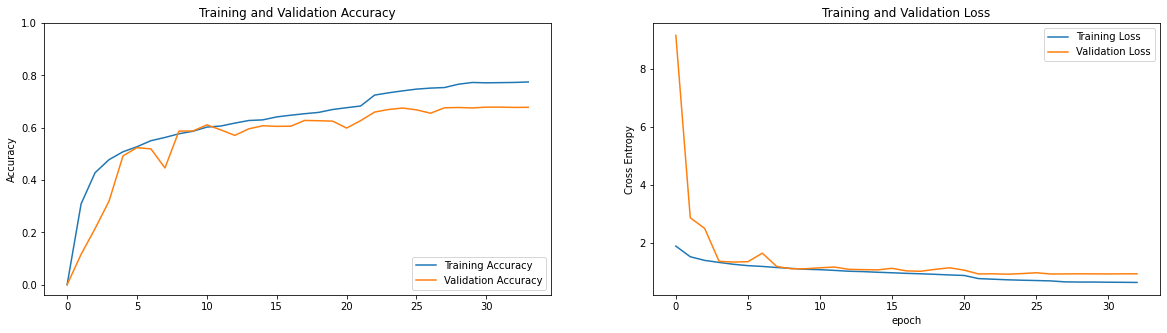

In [ ]:
# Plotting te accuracy and loss
plots(history)

<a name='2'></a>
# **VGG19**

In [ ]:
# categorical classification using VGG19 
model3 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                     Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                     # Using VGG19 and Flattening the output
                     VGG19(include_top=False), Flatten(), BatchNormalization(),
                     # Using 2 fully connected layer with 4096 units and relu activation
                     Dense(4096, activation='relu'), BatchNormalization(),
                     Dense(4096, activation='relu'), BatchNormalization(),
                     # Using a prediction layer with seven neuron
                     Dense(7, activation='softmax')])

# Compiling the model
model3.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
model3.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 3)         30        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 4096)              2101248   
                                                                 
 batch_normalization_7 (Batc  (None, 4096)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fitting the model
history = model3.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('vgg19'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.9825 - accuracy: 0.2395
Epoch 1: val_loss improved from inf to 2.82886, saving model to vgg19.h5
449/449 [==============================] - 43s 93ms/step - loss: 1.9825 - accuracy: 0.2395 - val_loss: 2.8289 - val_accuracy: 0.2685 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5947 - accuracy: 0.3808
Epoch 2: val_loss did not improve from 2.82886
449/449 [==============================] - 41s 90ms/step - loss: 1.5947 - accuracy: 0.3808 - val_loss: 3.2508 - val_accuracy: 0.3945 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.4519 - accuracy: 0.4463
Epoch 3: val_loss improved from 2.82886 to 1.34743, saving model to vgg19.h5
449/449 [==============================] - 42s 93ms/step - loss: 1.4519 - accuracy: 0.4463 - val_loss: 1.3474 - val_accuracy: 0.4882 - lr: 1.0000e-04
Epoch 4/100
449/449 [==============================] - ETA: 0s

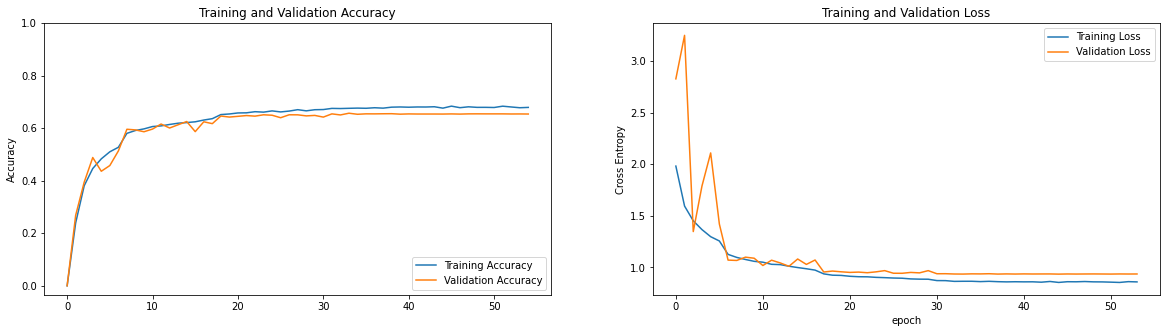

In [ ]:
# Plotting te accuracy and loss
plots(history)